In [78]:
from pathlib import Path
import torch
import pickle
import numpy as np
from collections import defaultdict
import pandas as pd
from scipy.special import softmax
from tqdm import tqdm
from multiprocessing import Pool

In [79]:
book_paths = Path('/home/allekim/stonybook-data/guten_hathi_alignment/')

In [85]:
parsed_book_results_paths = list(book_paths.glob('*/*_hathi_results.dt'))

In [86]:
len(parsed_book_results_paths)

820

In [35]:
def map_subtok_to_tok_idx(offsets):
    idx_mapping = []
    tok_num = -1
    for idx, pair in enumerate(offsets):
        s, e = pair
        if e == 0:
            continue
        if s == 1:
            tok_num += 1
        idx_mapping.append(tok_num)
    return idx_mapping

In [ ]:
num_errors = 0
thres = 0.95
for idx in range(len(inputs)):
    mask = np.where(np.array(inputs[idx]['attention_mask']) == 1)
    input_ids = np.array(inputs[idx]['input_ids'])[mask][1:-1]
    offsets = np.array(inputs[idx]['offset_mapping'])[mask]
    subtok_to_tok = np.array(map_subtok_to_tok_idx(offsets))
    
    preds = np.array(preda[idx])[mask][1:-1]
    pos_idx = np.where(preds[:,1] > thres)[0]
    pred = np.zeros(len(preds))
    pred[pos_idx] = 1
    if 1 in pred:
        pred_mask = np.where(pred==1)
        indices = subtok_to_tok[pred_mask]
        indices = sorted(set(indices))
        print(indices)
        ocr_toks = np.array(inputs[idx]['sent'])[indices]
        print(inputs[idx]['sent'])
#         print(preds)
#         print(pos_idx)
#         print(pred)t
#         print(pred_mask)
#         print(preds[pred_mask,1])
        print(ocr_toks)
        print()
        num_errors += 1
        

In [90]:
def score_book(result_path):
    output_path = result_path.parent / 'ocr_detection_results.pkl'
    if output_path.exists():
        return
    hathi_id = result_path.stem.split('_')[0]
    input_path = result_path.parent / '{}_hathi_input.dt'.format(hathi_id)
    aligned_df = pd.read_csv(result_path.parent / 'aligned_toks.csv', converters={'sent_idx2':eval})
    inputs = torch.load(input_path)
    results = torch.load(result_path)
    bad_sents = set()
    for x, y in aligned_df['sent_idx2']:
        if y - x > 1:
            continue
        bad_sents.add(x)
        bad_sents.add(y)
    preda = softmax(results.predictions, axis=-1)

    num_errors = 0
    thresholds = [0.5,0.6,0.7,0.8,0.9]
    bad_sent_caught = defaultdict(set)
    for idx in range(len(inputs)):
        mask = np.where(np.array(inputs[idx]['attention_mask']) == 1)
        input_ids = np.array(inputs[idx]['input_ids'])[mask][1:-1]
        offsets = np.array(inputs[idx]['offset_mapping'])[mask]
        subtok_to_tok = np.array(map_subtok_to_tok_idx(offsets))
        preds = np.array(preda[idx])[mask][1:-1]
        for thres in thresholds:
            pos_idx = np.where(preds[:,1] > thres)[0]
            if len(pos_idx) > 0:
                bad_sent_caught[thres].add(idx)
    #     pred = np.zeros(len(preds))
    #     pred[pos_idx] = 1
    #     if 1 in pred:
    #         bad_sent_caught.add(idx)
    #         pred_mask = np.where(pred==1)
    #         indices = subtok_to_tok[pred_mask]
    #         ocr_toks = np.array(inputs[idx]['sent'])[indices]
    #         print(inputs[idx]['sent'])
    #         print(confidence[idx][pred_mask])
    #         print(ocr_toks)
    #         print()
#             num_errors += 1
    inp_len = len(inputs)
    bsents = len(bad_sents)
    threshold_results = {}
    for thres in thresholds:
        intersection = bad_sent_caught[thres] & bad_sents
        threshold_results[thres] = (len(bad_sent_caught[thres]), len(intersection))
    results = inp_len, bsents, threshold_results
    with open(output_path, 'wb') as f:
        pickle.dump(results, f, 4)
    return results

In [91]:
# for result_path in parsed_book_results_paths:
#     score_book(result_path)

In [92]:
with Pool(30) as p:
    list(tqdm(p.imap_unordered(score_book, parsed_book_results_paths), total=len(parsed_book_results_paths)))

100%|██████████| 820/820 [19:53<00:00,  1.45s/it]


In [122]:
paths = list(Path('/home/allekim/stonybook-data/guten_hathi_alignment').glob('*/*_new.txt'))
real_paths = set()
for p in paths:
    with open(p) as f:
        l1, l2, overlap, match = map(int, next(f).split())
        if min(l1,l2) / max(l1,l2) < 0.9:
            continue
        real_paths.add(p.parent)
print(len(real_paths))

6390


In [123]:
results = defaultdict(list)
for p in parsed_book_results_paths:
    if p.parent in real_paths:
        with open(p.parent / 'ocr_detection_results.pkl', 'rb') as f:
            _, x, y = pickle.load(f)
            for thres in y:
                a, b = y[thres]
                results[thres].append((b, a-b, p.parent.stem))

In [124]:
import matplotlib.pyplot as plt

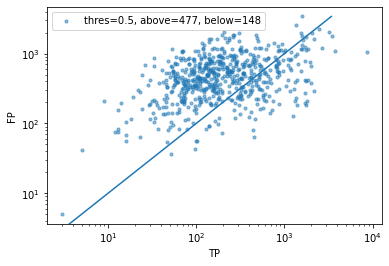

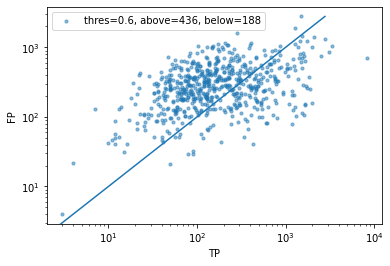

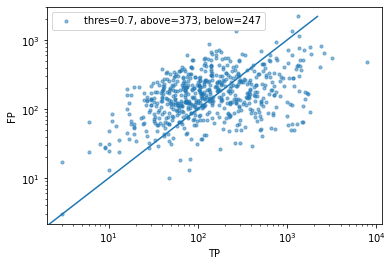

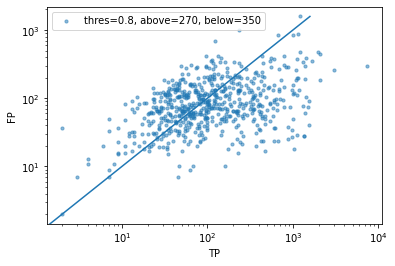

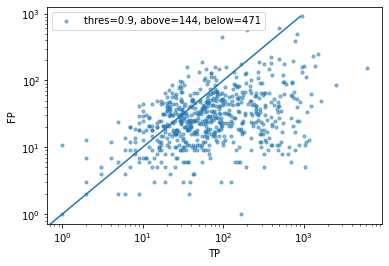

In [126]:
for thres in results:
    num_above = sum([x<y for x,y,_ in results[thres]])
    num_below = sum([x>y for x,y,_ in results[thres]])
    x, y, _ = zip(*results[thres])
    r = min(max(x), max(y))
    plt.scatter(x, y, alpha=0.5, s=10, label="thres={}, above={}, below={}".format(thres, num_above, num_below))
    plt.xscale('log')
    plt.yscale('log')
    plt.plot([0,r],[0,r])
    plt.xlabel('TP')
    plt.ylabel('FP')
    plt.legend()
    plt.show()

In [128]:
real_paths

{PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/38718'),
 PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/46475'),
 PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/43141'),
 PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/34367'),
 PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/18730'),
 PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/63729'),
 PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/19989'),
 PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/23946'),
 PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/33240'),
 PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/31787'),
 PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/36083'),
 PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/24268'),
 PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/12516'),
 PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/3

In [133]:
ocr_results = list(book_paths.glob('*/ocr_detection_results.pkl'))

In [139]:
list(p.parent.glob('*_new.txt'))[0].stem.split('_')[0]

'coo.31924013211432'

In [136]:
p

PosixPath('/home/allekim/stonybook-data/guten_hathi_alignment/16/ocr_detection_results.pkl')

In [140]:
hid_to_stats = {}
for p in ocr_results:
    hid = list(p.parent.glob('*_new.txt'))[0].stem.split('_')[0]
    with open(p, 'rb') as f:
        sents, bsents, thres = pickle.load(f)
        bad_detect, intersection = thres[0.9]
    hid_to_stats[hid] = (sents, bsents, bad_detect)

In [141]:
hid_to_stats

{'coo.31924013211432': (3183, 487, 69),
 'mdp.39015005089597': (3921, 241, 55),
 'nyp.33433074851126': (8062, 2782, 299),
 'dul1.ark+=13960=t98637h6g': (2021, 1106, 334),
 'loc.ark+=13960=t8jd5qx8n': (635, 216, 106),
 'uc2.ark+=13960=t9r20w429': (2094, 160, 109),
 'uc1.31158001183002': (7003, 952, 188),
 'nyp.33433074902499': (5565, 683, 90),
 'mdp.39015012333046': (5883, 622, 106),
 'nyp.33433075744890': (4349, 612, 75),
 'uc2.ark+=13960=t2794143s': (2396, 319, 271),
 'nyp.33433074940861': (5209, 900, 153),
 'uc2.ark+=13960=t3cz3334b': (6054, 1885, 380),
 'uc2.ark+=13960=t2r49vz0v': (4772, 2016, 1045),
 'uc2.ark+=13960=t1hh6d619': (13015, 1818, 1303),
 'njp.32101068602307': (4809, 121, 23),
 'njp.32101007172354': (4090, 230, 99),
 'uc1.b4102254': (7367, 1094, 196),
 'mdp.39015005391647': (4461, 219, 70),
 'uc2.ark+=13960=t82j6dh22': (4357, 658, 496),
 'uc1.b3727420': (9016, 647, 103),
 'nyp.33433075744866': (6447, 98, 27),
 'uc1.b4098203': (7283, 360, 99),
 'mdp.39015014648482': (2593

In [142]:
hathi_meta_df = pd.read_csv('/home/allekim/stonybook-data/normalized_hathi_metadata.csv')

In [144]:
hathi_date = dict(zip(hathi_meta_df.htid, hathi_meta_df.pub_date))

In [146]:
records = []
grecords = []
for hid in hid_to_stats:
    pub_date = hathi_date[hid]
    num_sent, bad, gbad = hid_to_stats[hid]
    records.append((pub_date, bad/num_sent))
    grecords.append((pub_date, gbad/num_sent))

In [159]:
from sklearn.linear_model import LinearRegression

In [168]:
reg = LinearRegression().fit(x.reshape(-1,1), y)

In [169]:
predy = reg.predict(x.reshape(-1,1))

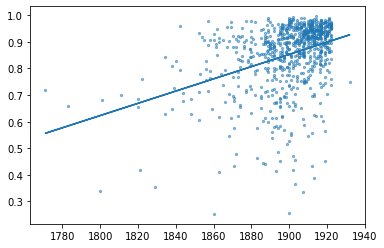

In [170]:
x, y = zip(*records)
x = np.array(x)
y = np.array([1-z for z in y])
plt.scatter(x,y,s=5,alpha=0.5)
plt.plot(x, predy)

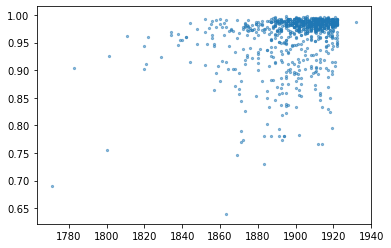

In [158]:
x, y = zip(*grecords)
y = [1-z for z in y]
plt.scatter(x,y,s=5,alpha=0.5)

In [173]:
df = pd.read_csv('/home/allekim/ocr-detection/deduplication/dedup_hathi.csv', converters={'hathi_id_set':eval})

In [178]:
s = set()
for idx, row in df.iterrows():
    s.update(row['hathi_id_set'])

In [179]:
len(s)

58808